<a href="https://www.kaggle.com/code/sagnikdebnath007/vae-2?scriptVersionId=211913535" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

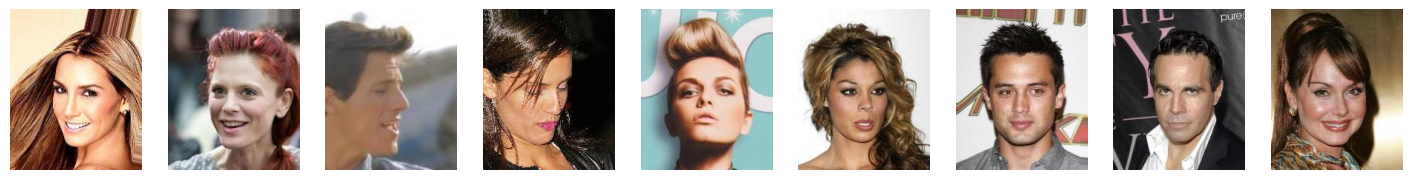

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
plt.figure(figsize=(20,20))
plt.subplots_adjust(hspace=0.4)

for i in range(1,10):   
    plt.subplot(1,10,i+1)    
    filename = '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/00000' + str(i) + '.jpg'
    image = imread(filename)
    plt.imshow(image)
    plt.axis('off')
plt.show()

In [2]:
import os
import torch 
import torch.nn as nn #nn layers
import torch.optim as optim #optimization algos
import torch.nn.functional as F #activation funcs like relu,tanh. Also included in nn
from torch.utils.data import Dataset,DataLoader,random_split #Makes data using easy
import torchvision.datasets as datasets #for datasets
import torchvision.transforms as transforms #used for data augmentation
from PIL import Image

In [3]:
class DatasetLoader(Dataset):
    def __init__(self,root,transform=False):
        self.root=root
        self.transform=transform
        self.img_paths=sorted(os.listdir(os.path.join(root, "img_align_celeba")))
    def __len__(self):
        return len(self.img_paths)
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "img_align_celeba", self.img_paths[idx])
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image

In [4]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [5]:
dataset=DatasetLoader(root='/kaggle/input/celeba-dataset/img_align_celeba',transform=transform)

In [6]:
val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [7]:
class VariationalAutoencoder(nn.Module):
    def __init__(self,input_dim=3,latent_dim=128):
        super(VariationalAutoencoder,self).__init__()
        self.input_dim=input_dim
        self.latent_dim=latent_dim
        self.encoder=nn.Sequential(
            nn.Conv2d(input_dim,16,kernel_size=6,stride=4,padding=1),
            nn.SiLU(),
            nn.Conv2d(16,32,kernel_size=6,stride=4,padding=1),
            nn.SiLU(),
            nn.Conv2d(32,64,kernel_size=6,stride=4,padding=1),
            nn.SiLU()    
        )
        self.mu=nn.Linear(64*4*4,latent_dim)
        self.logvar=nn.Linear(64*4*4,latent_dim)
        self.inver_flatten=nn.Linear(latent_dim,64*4*4)
        self.decoder=nn.Sequential(
            nn.ConvTranspose2d(64,32,kernel_size=6,stride=4,padding=1),
            nn.SiLU(),
            nn.ConvTranspose2d(32,16,kernel_size=6,stride=4,padding=1),
            nn.SiLU(),
            nn.ConvTranspose2d(16,input_dim,kernel_size=6,stride=4,padding=1),
            nn.Tanh()
        )

    def reparameterize(self,mu,logvar):
        eps=torch.randn_like(logvar)
        sigma=torch.exp(0.5*logvar)
        z=mu+eps*sigma
        return z

    def forward(self,x):
        batch_size=x.shape[0]
        encoded=self.encoder(x).view(batch_size,-1)
        mu=self.mu(encoded)
        logvar=self.logvar(encoded)
        z=self.reparameterize(mu,logvar)
        inverse_flattened=self.inver_flatten(z).view(batch_size,64,4,4)
        decoded=self.decoder(inverse_flattened)
        return decoded,mu,logvar

In [8]:
def vae_loss(x,x_hat,mask,mu,logvar):
    autoencoder_loss=nn.MSELoss(reduction='sum')(x_hat*mask,x*mask)
    kl_loss=-0.5*torch.sum(1+logvar-mu.pow(2)-torch.exp(logvar))
    return autoencoder_loss+kl_loss

In [9]:
from tqdm import tqdm

In [10]:
model = VariationalAutoencoder(input_dim=3, latent_dim=128).to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [11]:
model

VariationalAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(6, 6), stride=(4, 4), padding=(1, 1))
    (1): SiLU()
    (2): Conv2d(16, 32, kernel_size=(6, 6), stride=(4, 4), padding=(1, 1))
    (3): SiLU()
    (4): Conv2d(32, 64, kernel_size=(6, 6), stride=(4, 4), padding=(1, 1))
    (5): SiLU()
  )
  (mu): Linear(in_features=1024, out_features=128, bias=True)
  (logvar): Linear(in_features=1024, out_features=128, bias=True)
  (inver_flatten): Linear(in_features=128, out_features=1024, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(6, 6), stride=(4, 4), padding=(1, 1))
    (1): SiLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(6, 6), stride=(4, 4), padding=(1, 1))
    (3): SiLU()
    (4): ConvTranspose2d(16, 3, kernel_size=(6, 6), stride=(4, 4), padding=(1, 1))
    (5): Tanh()
  )
)

In [12]:
def apply_random_mask(images, mask_size=32):
    B, C, H, W = images.size()
    masked_images = images.clone()
    mask = torch.ones_like(images) 

    for i in range(B):
        top = torch.randint(0, H - mask_size, (1,))
        left = torch.randint(0, W - mask_size, (1,))
        masked_images[i, :, top:top+mask_size, left:left+mask_size] = 0
        mask[i, :, top:top+mask_size, left:left+mask_size] = 0

    return masked_images, mask

In [13]:
epochs=30
for epoch in range(epochs):
    model.train()
    train_loss=0.0
    for img in tqdm(train_loader,desc=f'Epoch:{epoch+1}'):
        img=img.to('cuda')
        
        masked_images, mask = apply_random_mask(img, mask_size=32)
        x_hat,mu,logvar=model(masked_images)
        
        x_hat=x_hat.to('cuda')
        mu=mu.to('cuda')
        logvar=logvar.to('cuda')
        
        loss=vae_loss(img,x_hat,mask,mu,logvar).to('cuda')
         
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()
    print(f"Loss: {train_loss / len(train_loader.dataset):.4f}")

Epoch:1: 100%|██████████| 20260/20260 [24:16<00:00, 13.91it/s]


Loss: 8594.9848


Epoch:2: 100%|██████████| 20260/20260 [13:37<00:00, 24.78it/s]


Loss: 6529.6381


Epoch:3: 100%|██████████| 20260/20260 [12:25<00:00, 27.17it/s]


Loss: 6280.3965


Epoch:4: 100%|██████████| 20260/20260 [12:35<00:00, 26.81it/s]


Loss: 6174.1326


Epoch:5: 100%|██████████| 20260/20260 [11:15<00:00, 30.00it/s]


Loss: 6110.3522


Epoch:6: 100%|██████████| 20260/20260 [11:37<00:00, 29.04it/s]


Loss: 6068.5829


Epoch:7: 100%|██████████| 20260/20260 [11:30<00:00, 29.34it/s]


Loss: 6037.5658


Epoch:8: 100%|██████████| 20260/20260 [11:38<00:00, 29.00it/s]


Loss: 6012.6837


Epoch:9: 100%|██████████| 20260/20260 [11:02<00:00, 30.59it/s]


Loss: 5991.3952


Epoch:10: 100%|██████████| 20260/20260 [10:57<00:00, 30.80it/s]


Loss: 5967.7181


Epoch:11: 100%|██████████| 20260/20260 [10:36<00:00, 31.83it/s]


Loss: 5943.4667


Epoch:12: 100%|██████████| 20260/20260 [10:43<00:00, 31.51it/s]


Loss: 5924.0393


Epoch:13: 100%|██████████| 20260/20260 [10:31<00:00, 32.06it/s]


Loss: 5909.3009


Epoch:14: 100%|██████████| 20260/20260 [10:27<00:00, 32.27it/s]


Loss: 5895.5617


Epoch:15: 100%|██████████| 20260/20260 [10:28<00:00, 32.23it/s]


Loss: 5885.0839


Epoch:16: 100%|██████████| 20260/20260 [10:30<00:00, 32.12it/s]


Loss: 5875.3077


Epoch:17: 100%|██████████| 20260/20260 [10:34<00:00, 31.93it/s]


Loss: 5867.0306


Epoch:18: 100%|██████████| 20260/20260 [10:34<00:00, 31.91it/s]


Loss: 5859.6090


Epoch:19: 100%|██████████| 20260/20260 [10:33<00:00, 31.98it/s]


Loss: 5852.1016


Epoch:20: 100%|██████████| 20260/20260 [10:29<00:00, 32.16it/s]


Loss: 5846.2096


Epoch:21: 100%|██████████| 20260/20260 [10:30<00:00, 32.12it/s]


Loss: 5840.8273


Epoch:22: 100%|██████████| 20260/20260 [10:50<00:00, 31.14it/s]


Loss: 5836.1494


Epoch:23: 100%|██████████| 20260/20260 [10:59<00:00, 30.72it/s]


Loss: 5830.3897


Epoch:24: 100%|██████████| 20260/20260 [10:26<00:00, 32.36it/s]


Loss: 5826.1696


Epoch:25: 100%|██████████| 20260/20260 [10:29<00:00, 32.16it/s]


Loss: 5822.0809


Epoch:26: 100%|██████████| 20260/20260 [10:20<00:00, 32.64it/s]


Loss: 5817.9869


Epoch:27: 100%|██████████| 20260/20260 [10:35<00:00, 31.90it/s]


Loss: 5814.2814


Epoch:28: 100%|██████████| 20260/20260 [10:53<00:00, 31.01it/s]


Loss: 5809.6375


Epoch:29: 100%|██████████| 20260/20260 [10:34<00:00, 31.92it/s]


Loss: 5806.7053


Epoch:30: 100%|██████████| 20260/20260 [10:23<00:00, 32.52it/s]

Loss: 5803.3516


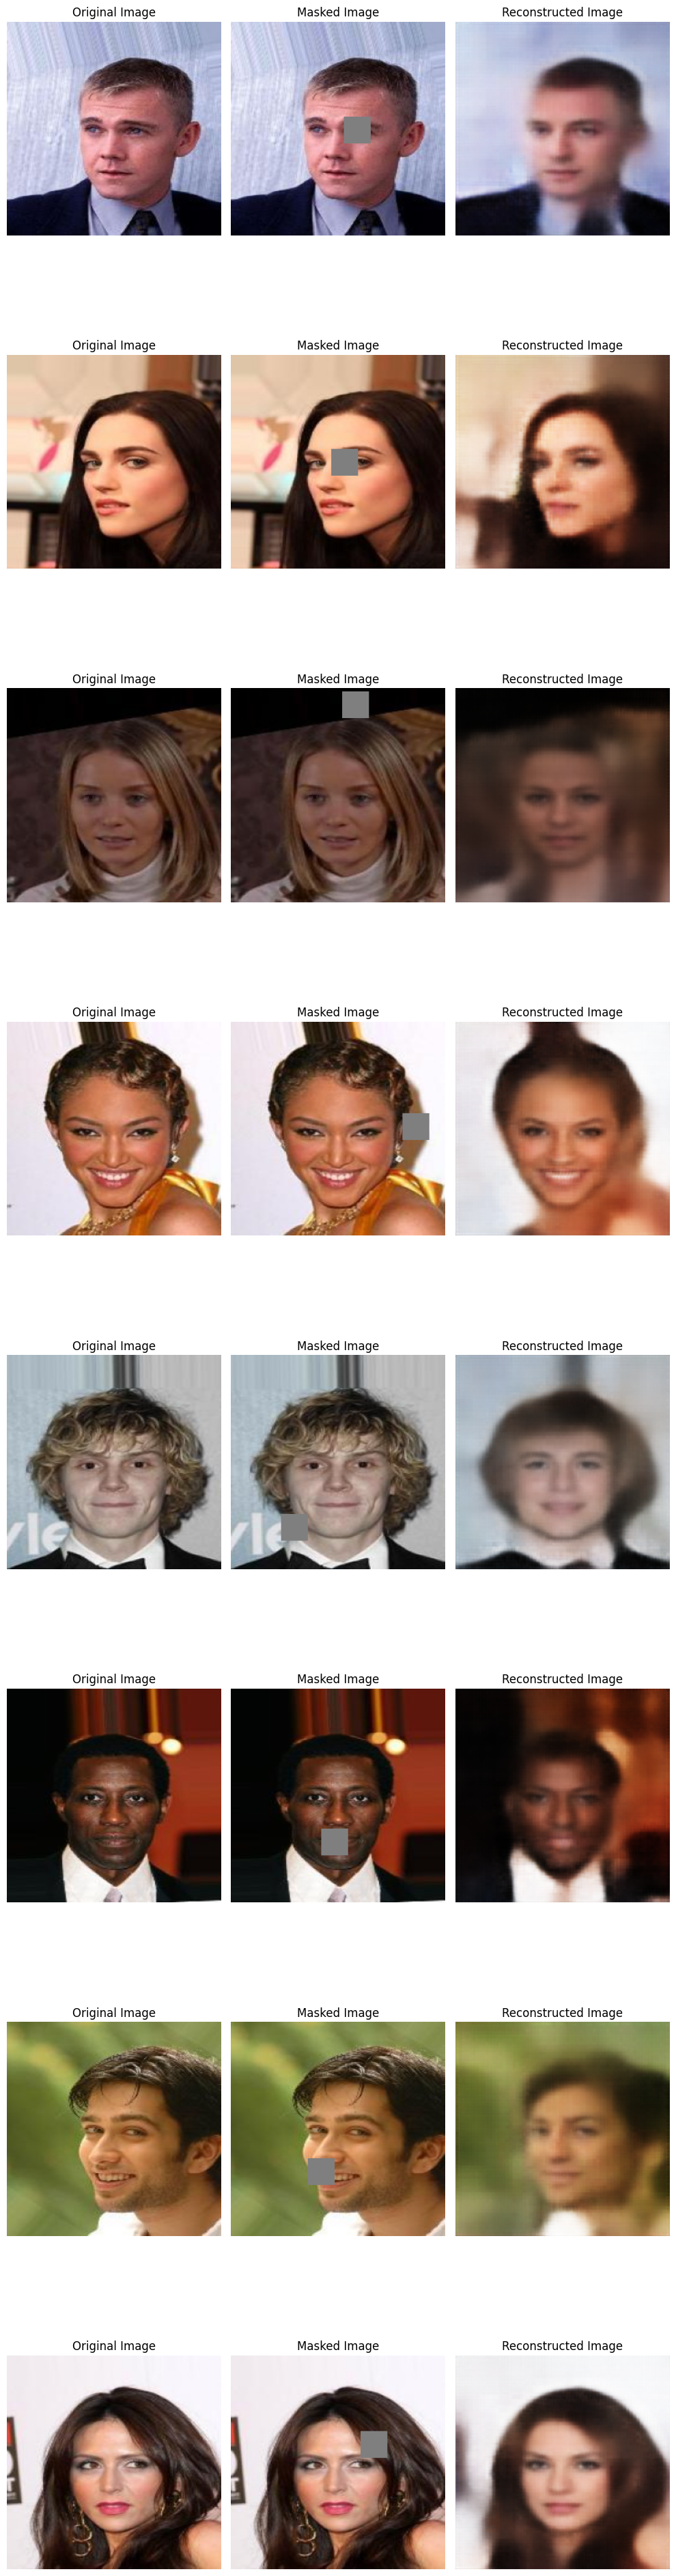

In [14]:
def visualize_inpainting(model, val_loader, mask_size=32, num_images=5):
    model.eval()
    with torch.no_grad():
        # Get a batch of validation data
        images = next(iter(val_loader))
        images = images.to('cuda')

        # Apply random masks
        masked_images, mask = apply_random_mask(images, mask_size=mask_size)

        # Reconstruct images
        reconstructed, _, _ = model(masked_images)

    # Denormalize for visualization
    images = torch.clamp(images * 0.5 + 0.5, 0, 1).cpu()
    masked_images = torch.clamp(masked_images * 0.5 + 0.5, 0, 1).cpu()
    reconstructed = torch.clamp(reconstructed * 0.5 + 0.5, 0, 1).cpu()

    # Visualize
    fig, axes = plt.subplots(num_images, 3, figsize=(10, 5 * num_images))
    for i in range(num_images):
        axes[i, 0].imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(np.transpose(masked_images[i].numpy(), (1, 2, 0)))
        axes[i, 1].set_title("Masked Image")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(np.transpose(reconstructed[i].numpy(), (1, 2, 0)))
        axes[i, 2].set_title("Reconstructed Image")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()
    
visualize_inpainting(model, val_loader, mask_size=32, num_images=8)